In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [53]:
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Activation,Dropout,BatchNormalization
from keras.applications.resnet50 import ResNet50,preprocess_input
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint,EarlyStopping
from sklearn.model_selection import train_test_split

In [4]:
cd /content/drive/MyDrive/Dl_Lab

/content/drive/MyDrive/Dl_Lab


In [55]:
# !unzip train_nLPp5K8.zip

In [14]:
seed = 42
rnp = np.random.RandomState(seed)

In [13]:
df = pd.read_csv("train.csv")

In [12]:
df.head()

,image_names,class
0,11413.jpg,1
1,9863.jpg,1
2,997.jpg,0
3,5950.jpg,0
4,10454.jpg,1


In [11]:
X = []

for image_name in df["image_names"]:
  img = plt.imread("images/" + image_name)
  X.append(img)


In [15]:
X = np.array(X)

In [16]:
y = df["class"].values

In [17]:
X.shape

(12196, 224, 224, 3)

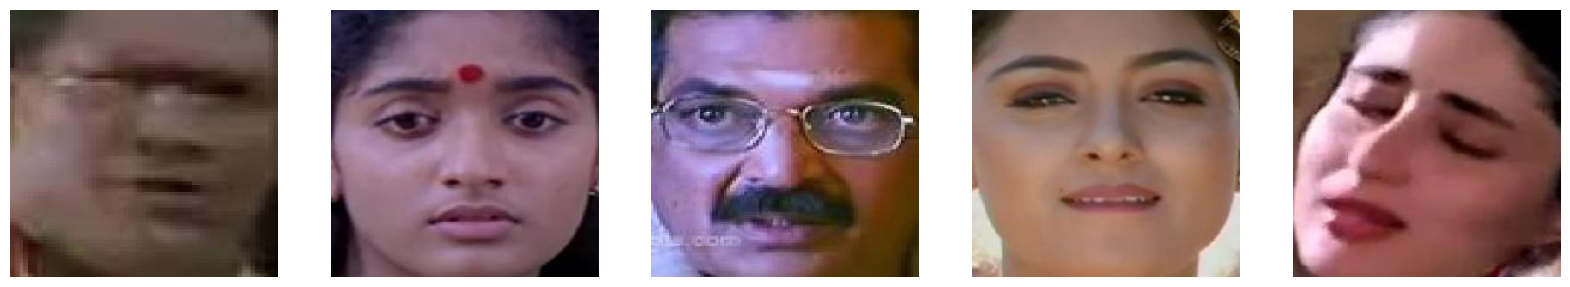

In [18]:
fig,ax = plt.subplots(nrows=1,ncols=5,figsize=(20,20))
for i in range(5):
  ax[i].imshow(X[i*400])
  ax[i].axis('off')


In [19]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.3,random_state=seed)

In [20]:
base_model = ResNet50(input_shape=(224,224,3),include_top=False,weights="imagenet")

94765736/94765736 [==============================] - 1s 0us/step


In [21]:
for layer in base_model.layers:
    layer.trainable=False

In [22]:
#pretrain model that alredy have cnn architecture
model = Sequential()
model.add(base_model)
model.add(Dropout(.2))

#make my own architecture
#1st layer
model.add(Conv2D(512,(3,3),strides=(1,1),activation="relu",padding="same"))
model.add(BatchNormalization())
model.add(Dropout(.1))

#2nd layer
model.add(Conv2D(128,(3,3),strides=(1,1),activation="relu",padding="same"))
model.add(BatchNormalization())
model.add(Dropout(.1))

#3rd layer
model.add(Conv2D(384,(3,3),strides=(1,1),activation="relu",padding="same"))
model.add(BatchNormalization())
model.add(Dropout(.1))

#4th layer
model.add(Conv2D(384,(3,3),strides=(1,1),activation="relu",padding="same"))
model.add(BatchNormalization())
model.add(Dropout(.1))

#5th layer
model.add(Conv2D(500,(3,3),strides=(1,1),activation="relu",padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,strides=(2,2),padding="same"))

#after this convert all the layer into 1d so for that we used flatten

model.add(Flatten())
model.add(Dense(2048 , activation='relu'))
model.add(Dropout(.2))
model.add(Dense(2048 , activation='relu'))
model.add(Dropout(.2))
model.add(Dense(2048, activation='relu'))
model.add(Dropout(.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 dropout (Dropout)           (None, 7, 7, 2048)        0         
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 512)         9437696   
                                                                 
 batch_normalization (Batch  (None, 7, 7, 512)         2048      
 Normalization)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 512)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         589952    
                                                        

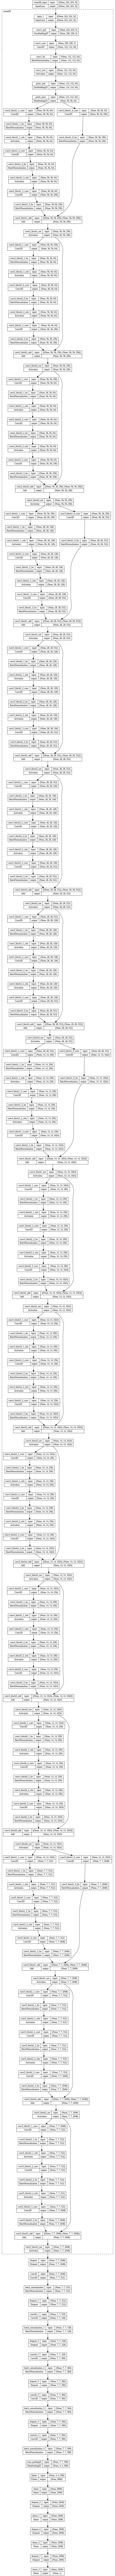

In [23]:
from keras.utils import plot_model
plot_model(model,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

In [24]:
model.compile(optimizer='adam',
              loss='binary_crossentropy'
              ,metrics=['accuracy'])

In [25]:
lrd = ReduceLROnPlateau(monitor = 'val_accuracy',
                        patience = 3,
                        verbose = 1 ,
                        factor = 0.5,
                        min_lr = 0.0001)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(monitor = 'val_accuracy',verbose=1, patience=3)

In [26]:
%time
hist = model.fit(X_train,
                 y_train,
                 epochs=10,
                 batch_size=64,
                 validation_data=(X_test,y_test),
                 callbacks=[lrd, mcp, es])

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs
Epoch 1/10
134/134 [==============================] - ETA: 0s - loss: 0.9237 - accuracy: 0.7663

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


134/134 [==============================] - 108s 637ms/step - loss: 0.9237 - accuracy: 0.7663 - val_loss: 0.5392 - val_accuracy: 0.7622 - lr: 0.0010
Epoch 2/10
134/134 [==============================] - 60s 452ms/step - loss: 0.2876 - accuracy: 0.8824 - val_loss: 0.2801 - val_accuracy: 0.8860 - lr: 0.0010
Epoch 3/10
134/134 [==============================] - 67s 501ms/step - loss: 0.1872 - accuracy: 0.9263 - val_loss: 0.3665 - val_accuracy: 0.8644 - lr: 0.0010
Epoch 4/10
134/134 [==============================] - 62s 466ms/step - loss: 0.1410 - accuracy: 0.9475 - val_loss: 0.3693 - val_accuracy: 0.8863 - lr: 0.0010
Epoch 5/10
134/134 [==============================] - 68s 513ms/step - loss: 0.1100 - accuracy: 0.9588 - val_loss: 0.4287 - val_accuracy: 0.8833 - lr: 0.0010
Epoch 6/10
134/134 [==============================] - 73s 546ms/step - loss: 0.0827 - accuracy: 0.9726 - val_loss: 0.5010 - val_accuracy: 0.8385 - lr: 0.0010
Epoch 7/10
134/134 [==============================] - ETA: 0s 

In [27]:
from keras.models import load_model
model = load_model("model.h5")

In [28]:
h = hist.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

<ipython-input-29-6d73d575ddd1>:1: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go--" (-> color='g'). The keyword argument will take precedence.
  plt.plot(h["loss"],"go--",color="green")
<ipython-input-29-6d73d575ddd1>:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go--" (-> color='g'). The keyword argument will take precedence.
  plt.plot(h["accuracy"],"go--",color="red")


Text(0.5, 1.0, 'Loss Vs Acc')

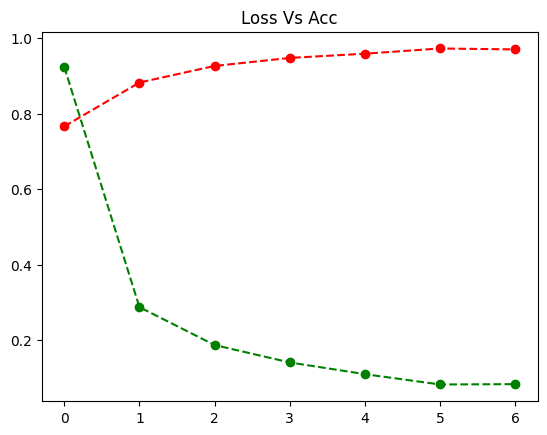

In [29]:
plt.plot(h["loss"],"go--",color="green")
plt.plot(h["accuracy"],"go--",color="red")

plt.title("Loss Vs Acc")

In [30]:
df_test  = pd.read_csv("test_fkwGUNG.csv")
df_test.head()

,image_names
0,5603.jpg
1,1286.jpg
2,9815.jpg
3,8865.jpg
4,9306.jpg


In [35]:
#i have differ dataset for chaeck that images is male or female
X_valid = []
for img_name in df_test.image_names:
 img = plt.imread('images/' + img_name)
 X_valid.append(img)

In [33]:
prediction_probabilities = model.predict(X_test)[:, 0]
classes_predictions=np.argmax(prediction_probabilities)

115/115 [==============================] - 16s 112ms/step


this much probability 100 % sure that it is Male
And actual class is  1


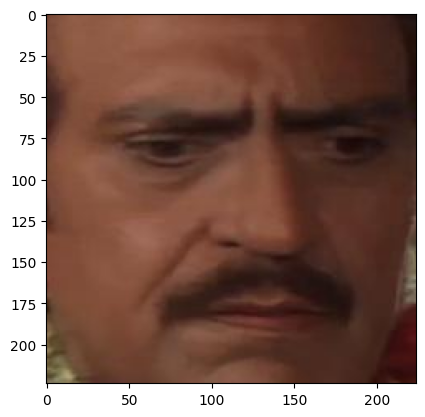

In [54]:
_, valid_vehicles, _, valid_y =train_test_split(df.image_names.values, y, test_size=0.3, random_state=seed)

index = rnp.choice(range(len(valid_vehicles)))

img_name = valid_vehicles[index]
prob = (prediction_probabilities * 100).astype(int)[index]
img = plt.imread('images/' + img_name)

print('this much probability', prob , '% sure that it is Male')
print('And actual class is ', valid_y[index])

plt.imshow(img)